### Q1. Why is it important to scale the inputs when using SVMs?
( Use any data, e.g Iris)

Support Vector Machines are typically applied to classification problems, where they use feature similarity to predict the class of a target variable. To explain how this works, the concept of a phase space is useful. Within a phase space, features are represented as having a spatial relationship to one another. The distance between features is used to make inferences about similarity (and implicitly about the structure of the data). Without scaling, these distances may have more to do with the magnitude, units, or range of each feature than the underlying relationship. For example, a persons weight expressed in grams would influence an algorithm that classifies a person as healthy or unhealthy more than the same weight expressed in pounds. So essentially, scaling makes it possible for a machine to discern the salient relationships.

In [31]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sb
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.svm import LinearSVC, SVC
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from scipy import sparse
%matplotlib inline

In [3]:
# load the data and divide it into features and target
iris = datasets.load_iris()
X = iris["data"]
y = iris["target"]
scaler = StandardScaler().fit(X)
X_transformed = scaler.transform(X)

In [4]:
model = LinearSVC(loss = 'hinge')
cv_results = model_selection.cross_val_score(model, X, y, cv =10, scoring = 'accuracy')
results = cv_results.mean()
# Accuracy = number of correct predictions / total number or predictions
# A good metric for demonstrating the importance of feature scaling
f'The average accuracy for unscaled data is {results}'

'The average accuracy for unscaled data is 0.9466666666666667'

In [5]:
cv_results = model_selection.cross_val_score(model, X_transformed, y, cv = 10, scoring = 'accuracy')
scaled_results = cv_results.mean()
    
f'The average accuracy for scaled data is {scaled_results}'

'The average accuracy for scaled data is 0.9133333333333333'

This result is unexpected. A possible explanation is that some of the features are near constant, except for noise. If this is the case, standardization will amplify the noise. 

Upon second thought, this result makes sense. The columns represent ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']. The scale is significant in this case, and by stripping the magnitudes we are losing information.

### Q2. How can an SVM classifier output a confidence score when it classifies an instance? demonstrate with a block of code.

To return a confidence score, we have to use the SVC class rather than LinearSVC. The latter is implemented in the liblinear library rather than libsvm, which makes it well suited to classification with a linear kernel, but unfit for other tasks. The SVC class has a property 'probability' which can be set to true. Then, the predict_proba() method is called after we fit the model.

In [7]:
classifier = SVC(probability=True)
model = classifier.fit(X,y)
#model.predict_proba(X)...don't run
confidence = pd.DataFrame(model.predict_proba(X)).iloc[::10,:]
confidence.columns = ['Setosa', 'Versicolor', 'Virginica']
Set = confidence.Setosa[(confidence.Setosa > 0.959666)].mean()
Ver = confidence.Versicolor[(confidence.Versicolor > 0.497529)].mean()
Vir = confidence.Virginica[(confidence.Virginica > 0.898209)].mean()
quickrows = pd.DataFrame([Set, Ver, Vir], index= ['Setosa', 'Versicolor', 'Virginica']
                        , columns = ['Mean'])
confidence.append(quickrows, sort = False)

,Setosa,Versicolor,Virginica,Mean
0,0.972071,0.014004,0.013925,NaN
10,0.967368,0.017631,0.015001,NaN
20,0.957512,0.026308,0.016180,NaN
30,0.963583,0.020316,0.016101,NaN
40,0.972647,0.013227,0.014126,NaN
50,0.016034,0.956922,0.027044,NaN
60,0.015580,0.947631,0.036789,NaN
70,0.012426,0.495200,0.492374,NaN
80,0.006787,0.986938,0.006275,NaN
90,0.007293,0.962295,0.030412,NaN


The above chart is a rough sketch of the how confident the classifier is in its predictions. It is important to note that these values are not actually probabilites, and while they may be provide a useful indication about the model, the mathematical soundness of these scores is debatable.

### Q3. If you train an SVM classifier with an RBF Kernel and you find out that it underfits the training set. Should you increase/ decrease the gamma? What about C? write a code to prove your statement.

We can correct underfitting by increasing c and gamma. Increasing c will make the margins of the decision boundary narrower, which reduces margin violations and makes the decision boundary more responsive to the variance of the training data. To explain the  effect of gamma on fit, it is necessary to discuss 'feature similarity' transformations.

We can generate a new feature by selecting a landmark instance and evaluating the relative similarity (distance) of all other instances. If gamma is small, the 'influence' of the landmark instance will be large, and the new feature will represent all other instances as similar to the landmark (even if they are not). If gamma is large, the influence of the landmark instance will be small, and the new feature may underrepresent the similarity of nearby instances. An appropriate gamma will increase the separability of the target class. The process can be repeated m times.

We can evaluate whether a classifier is underfitting a model by plotting a learning curve. If the train and test data have a similar error when the set size is sufficiently large, the model is likely underfitting. In this case, it is more appropriate to compare the cross validated accuracy for ranges of c and gamma (selected arbitrarily).

In [48]:
gamma_range = [0.1, 1, 5, 10, 100]
C_range = [0.001, 0.01, 0.1, 1, 10]
classifiers = []
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [0.1, 1, 5, 10, 100], 'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [46]:
#from the docs
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

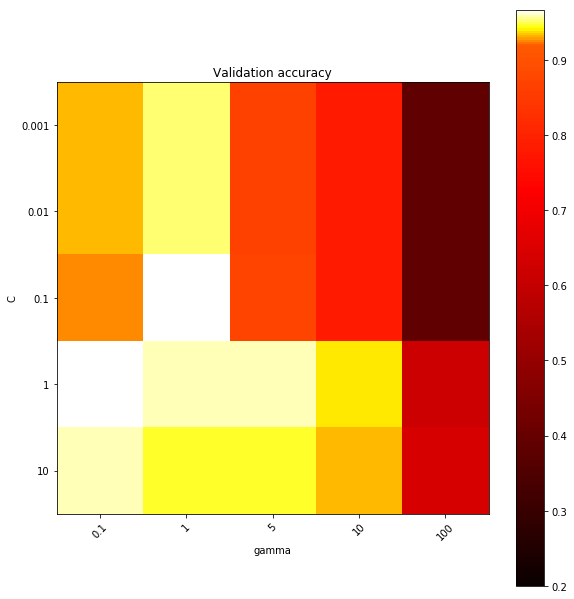

In [49]:
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

The iris data is quite simple, so similarity based transformations have limited use, but margin adjustments appear fairly important.

### Q4. How can you train a SVM regressor on a sample data?


This question is slightly ambiguous, but I will get clarification and update the submission.